
# Ensemble Classification




In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import pandas as pd
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import neighbors, datasets
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from scipy.spatial import ConvexHull
%matplotlib inline

In [2]:
Df=pd.read_csv('../datasets/CAD-PTSDData.csv')
X=Df.drop(['record_id','PTSDDx'],axis=1).values
y=Df.drop(['record_id'],axis=1).PTSDDx.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

In [100]:
Dp0=pd.read_csv('./data_st/S_MPOS_27_100',delimiter=" ",header=None)
Dn0=pd.read_csv('./data_st/S_MNEG_27_100',delimiter=" ",header=None)

Dp0s=Dp0
Dn0s=Dn0.sample(Dp0s.index.size)
Dn0s=Dn0.sample(2000)


D=pd.concat([Dp0s,Dn0s])
X=D.values
y=np.append(np.zeros([Dp0s.index.size,1]),np.ones([Dn0s.index.size,1]))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

In [3]:
FPR=[]
TPR=[]

0.6830357142857143
0.8627232142857143
0.8698660714285714
0.8136160714285715
0.7602678571428572


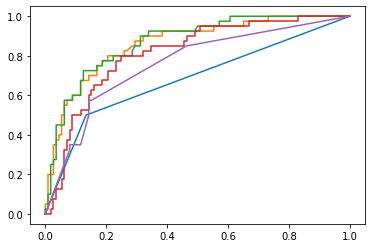

In [5]:
CLASSIFIERS=[DecisionTreeClassifier(max_depth=None, min_samples_split=2,
     random_state=0),
            RandomForestClassifier(n_estimators=1000, max_depth=None),
            ExtraTreesClassifier(n_estimators=1000, max_depth=None,
     min_samples_split=2),
            AdaBoostClassifier(n_estimators=1000),
            GradientBoostingClassifier(n_estimators=1000,max_depth=None)]

for clf in CLASSIFIERS:
    clf.fit(X_train,y_train)
    y_pred=clf.predict_proba(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred[:,1], pos_label=1)
    auc=metrics.auc(fpr, tpr)
    print(auc)
    
    plt.plot(fpr,tpr)

    FPR=np.append(FPR,fpr)
    TPR=np.append(TPR,tpr)

In [6]:
# MERGE DECISIONS TO BOOST AUC

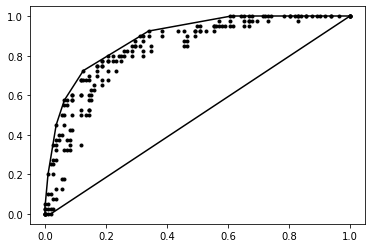

In [7]:
points=np.array([[a[0],a[1]] for a in zip(FPR,TPR)])
hull = ConvexHull(points)

plt.plot(points[:,0],points[:,1],'.k')
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')

In [9]:
x=np.argsort(points[hull.vertices,:][:,0])
auc=metrics.auc(points[hull.vertices,:][x,0],points[hull.vertices,:][x,1])
print(auc)

0.887611607142857


In [12]:
def getAuc(X,y,test_size=0.25,max_depth=None,n_estimators=100,minsplit=4,FPR=[],TPR=[],VERBOSE=False, USE_ONLY=None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    CLASSIFIERS=[DecisionTreeClassifier(max_depth=max_depth, min_samples_split=minsplit),
                RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,min_samples_split=minsplit),
                ExtraTreesClassifier(n_estimators=n_estimators, max_depth=max_depth,min_samples_split=minsplit),
                AdaBoostClassifier(n_estimators=n_estimators),
                GradientBoostingClassifier(n_estimators=n_estimators,max_depth=max_depth),
                svm.SVC(kernel='rbf',gamma='scale',class_weight='balanced',probability=True)]

    if USE_ONLY is not None:
        CLASSIFIERS=[CLASSIFIERS[USE_ONLY]]
    for clf in CLASSIFIERS:
        clf.fit(X_train,y_train)
        y_pred=clf.predict_proba(X_test)
        fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred[:,1], pos_label=1)
        auc=metrics.auc(fpr, tpr)
        if VERBOSE:
            print(auc)

        #plt.plot(fpr,tpr)

        FPR=np.append(FPR,fpr)
        TPR=np.append(TPR,tpr)
    points=np.array([[a[0],a[1]] for a in zip(FPR,TPR)])
    hull = ConvexHull(points)
    x=np.argsort(points[hull.vertices,:][:,0])
    auc=metrics.auc(points[hull.vertices,:][x,0],points[hull.vertices,:][x,1])
    return auc#,CLASSIFIERS

In [13]:
R={}
for depth in np.arange(4,20):
    ACC=[]
    for i in range(20):
        ACC=np.append(ACC,getAuc(X,y,minsplit=2,max_depth=depth))
    R[depth]=np.mean(ACC)
    print(depth,np.mean(ACC))

4 0.8919077694565761
5 0.8804396226116433
6 0.885271579508748
7 0.8882095598467578
8 0.8913700889888704
9 0.902273792418522
10 0.8767726575492963
11 0.9065533677871201
12 0.8914589884761508
13 0.8861042522342368
14 0.8924724782097531
15 0.8893464515775458
16 0.8806222605696163
17 0.888028871712021
18 0.8899673270853444
19 0.8930473525825727


In [16]:
RR=np.array([[k,v] for (k,v) in R.items()])
RR.shape

(16, 2)

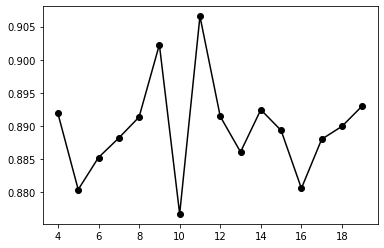

In [17]:
plt.plot(RR[:,0],RR[:,1],'-ko')

In [18]:
from tqdm import tqdm
P=[]
for i in tqdm(range(100)):
    P=np.append(P,getAuc(X,y,minsplit=2,max_depth=2))

100%|██████████| 100/100 [01:21<00:00,  1.22it/s]


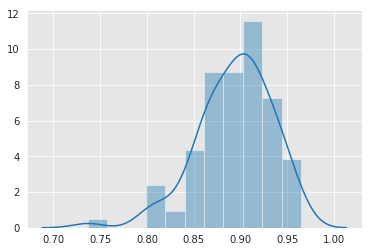

In [113]:
sns.distplot(P)

In [166]:
P1=[]
for i in tqdm(range(100)):
    P1=np.append(P1,getAuc(X,y,minsplit=2,max_depth=2,n_estimators=5,USE_ONLY=None))
    

100%|██████████| 100/100 [00:08<00:00, 11.49it/s]


0.9033794804471496


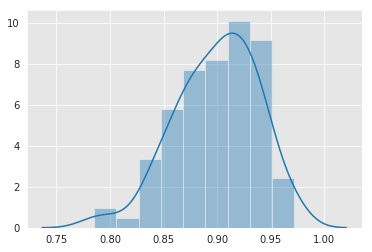

In [167]:
sns.distplot(P1)
print np.median(P1)

In [195]:
[auc0,clf]=getAuc(X,y,minsplit=2,max_depth=10,n_estimators=100,VERBOSE=False,USE_ONLY=5)

In [196]:
auc0

0.9113984674329503

In [198]:
clf[0].n_support_ 

array([106,  59], dtype=int32)